In [ ]:
getwd()
setwd('..')
getwd()

In [2]:
library(Matrix)
library(Seurat)

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/ch6845/tools/miniconda3/envs/MarcoPolo/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=C                LC_NUMERIC=C             
 [3] LC_TIME=en_IN.utf8        LC_COLLATE=en_IN.utf8    
 [5] LC_MONETARY=en_IN.utf8    LC_MESSAGES=en_IN.utf8   
 [7] LC_PAPER=en_IN.utf8       LC_NAME=C                
 [9] LC_ADDRESS=C              LC_TELEPHONE=C           
[11] LC_MEASUREMENT=en_IN.utf8 LC_IDENTIFICATION=C      

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Seurat_3.2.1 Matrix_1.3-2

loaded via a namespace (and not attached):
  [1] nlme_3.1-151         matrixStats_0.58.0   RcppAnnoy_0.0.18    
  [4] RColorBrewer_1.1-2   httr_1.4.2           repr_1.1.3          
  [7] sctransform_0.3.2    tools_4.0.3          utf8_1.2.1          
 [10] R6_2.5.0         

In [20]:
library(stringr)

In [21]:
#cc.genes$s.genes

In [22]:
#cc.genes$g2m.genes

In [23]:
#cc.genes

In [ ]:
read_in_data <-function(save_name){
    exp_data=readMM(sprintf("datasets/extract/%s.data.counts.mm",save_name))
 
    exp_data_row=read.table(sprintf('datasets/extract/%s.data.row',save_name))$V1
    exp_data_col=read.table(sprintf('datasets/extract/%s.data.col',save_name))$V1    
    rownames(exp_data)=exp_data_row
    colnames(exp_data)=exp_data_col    

    metadatarow=read.table(sprintf('datasets/extract/%s.metadatarow.tsv',save_name),sep='\t')
    metadatacol=read.table(sprintf('datasets/extract/%s.metadatacol.tsv',save_name),sep='\t')  
    
    metadatacol['size_factor']=read.table(sprintf('datasets/extract/%s.size_factor.tsv',save_name),sep='\t')$V1

    sce <- SingleCellExperiment(list(counts=as.matrix(exp_data)),rowData=metadatarow,colData=metadatacol)
    sce
}  

calculate_low_dim <-function(sce, pca_dim=10){
    counts = assay(sce, "counts")
    seurat <- CreateSeuratObject(counts = counts, project = "scRNAseq", assay = "RNA",
                                         min.cells = 0, min.features = 0)
    
    seurat <- NormalizeData(seurat); seurat <- ScaleData(seurat,features = rownames(seurat)); seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)
    seurat <- RunPCA(seurat, features = VariableFeatures(object = seurat)); seurat <- RunTSNE(seurat, dims= 1:pca_dim)
    reducedDims(sce) <- list(PCA=Embeddings(seurat, reduction = "pca")[,1:pca_dim], TSNE=Embeddings(seurat, reduction = "tsne"))
    sce
}

In [25]:
dataset_name_all=list(
'Kohinbulk_filtered',
'HumanLiver_filtered',
'Zhengmix8eq_filtered')

length(dataset_name_all)

[1] 3

In [26]:
dataset_name_all

[[1]]
[1] "Kohinbulk_filtered"

[[2]]
[1] "HumanLiver_filtered"

[[3]]
[1] "Zhengmix8eq_filtered"

In [27]:
dataset_name_all=list("TabulaAorta_filtered",
"TabulaBladder_filtered",
"TabulaBrainMyeloid_filtered",
"TabulaBrainNonMyeloid_filtered",
"TabulaDiaphragm_filtered",
"TabulaFat_filtered",
"TabulaHeart_filtered",
"TabulaKidney_filtered",
"TabulaLargeIntestine_filtered",
"TabulaLimbMuscle_filtered",
"TabulaLiver_filtered",
"TabulaLung_filtered",
"TabulaMammaryGland_filtered",
"TabulaMarrow_filtered",
"TabulaPancreas_filtered",
"TabulaSkin_filtered",
"TabulaSpleen_filtered",
"TabulaThymus_filtered",
"TabulaTongue_filtered",
"TabulaTrachea_filtered")

In [11]:
dataset_name_all=list("Pancreas_filtered")

In [12]:
dataset_name_all=list()
for (ncells_total in c('1000','2000','5000','10000')){
    for (prop in c('1e-2','5e-3','1e-3','5e-4')){
        for(i in c(1:10)){
            dataset_name<-sprintf('Simul_%s_%s_%s_filtered',ncells_total,prop,i)
            dataset_name_all<-append(dataset_name_all,dataset_name)
        }

    }
}

In [28]:
dataset_name_all=c('Splatter_5000_1_filtered')

In [29]:
for(dataset_name in dataset_name_all[1:length(dataset_name_all)]){
    for (res in c(0.5,1.0,1.5)){
        print(dataset_name)
        print(res)
        
        start_time=as.numeric(Sys.time())
        res_str=str_replace(sprintf('%.1f',res),fixed('.'),'_')

        sce=read_in_data(dataset_name);seurat=as.Seurat(sce, data=NULL)

        seurat_hvg <- NormalizeData(seurat)

        all.genes <- rownames(seurat_hvg)
        seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

        seurat_hvg <- FindVariableFeatures(seurat_hvg, selection.method = "vst", nfeatures = 2000)

        seurat_hvg_pca <- RunPCA(seurat_hvg, features = VariableFeatures(object = seurat_hvg))


        seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
        seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = res)
        seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)    

        DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")   

        DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")    

        write.table(seurat_hvg_pca_label_cluster_tsne@meta.data['seurat_clusters'],
                    sprintf('datasets/extract/%s.clustering.%s.label.tsv',dataset_name,res_str),sep='\t')
        
        end_time=as.numeric(Sys.time())
        
        time_preprocessing=end_time-start_time
        
        Idents(seurat_hvg_pca_label_cluster)=seurat_hvg_pca_label_cluster@meta.data['seurat_clusters']
        
        start_time=as.numeric(Sys.time())
        markers <- FindAllMarkers(seurat_hvg_pca_label_cluster, test.use="wilcox")#, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
        write.table(markers,
                    sprintf('datasets/extract/%s.clustering.%s.deg.tsv',dataset_name,res_str),sep='\t')    
        end_time=as.numeric(Sys.time())
        time_deg=end_time-start_time
        
        write.table(time_preprocessing+time_deg,
                    file=sprintf('datasets/extract/%s.clustering.%s.deg.runtime.tsv',dataset_name,res_str),
                    sep='\t',
                    row.names=FALSE, 
                    col.names=FALSE)          
        
        start_time=as.numeric(Sys.time())
        markers_all <- FindAllMarkers(seurat_hvg_pca_label_cluster, test.use="wilcox",logfc.threshold =0)#, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
        write.table(markers_all,
                    sprintf('datasets/extract/%s.clustering.%s.deg.all.tsv',dataset_name,res_str),sep='\t')  
        end_time=as.numeric(Sys.time())
        time_deg_all=end_time-start_time
        
        write.table(time_preprocessing+time_deg_all,
                    file=sprintf('datasets/extract/%s.clustering.%s.deg_all.runtime.tsv',dataset_name,res_str),
                    sep='\t',
                    row.names=FALSE, 
                    col.names=FALSE)
        
        rm(list=c('seurat','seurat_hvg','seurat_hvg_pca','seurat_hvg_pca_label','seurat_hvg_pca_label_cluster','seurat_hvg_pca_label_cluster_tsne'))
        

    }
    write.table(Embeddings(seurat_hvg_pca_label_cluster_tsne[['tsne']]),
                file=sprintf('datasets/extract/%s.tsne.vst.2000.tsv',dataset_name),
                sep='\t',
                row.names=TRUE,
                col.names=TRUE
               )     
    
}

[1] "Splatter_5000_1_filtered"
[1] 0.5


Centering and scaling data matrix

PC_ 1 
Positive:  Gene1302, Gene1862, Gene2263, Gene4259, Gene4710, Gene2936, Gene992, Gene292, Gene3865, Gene1715 
	   Gene556, Gene688, Gene4448, Gene725, Gene1237, Gene2538, Gene2175, Gene1424, Gene912, Gene4637 
	   Gene56, Gene3426, Gene607, Gene1069, Gene1527, Gene895, Gene1362, Gene4604, Gene1572, Gene873 
Negative:  Gene2988, Gene1532, Gene4896, Gene2265, Gene1749, Gene4048, Gene4050, Gene154, Gene1976, Gene1319 
	   Gene3827, Gene930, Gene1825, Gene3656, Gene103, Gene3734, Gene4272, Gene3370, Gene4364, Gene302 
	   Gene211, Gene1400, Gene780, Gene4475, Gene443, Gene3997, Gene3280, Gene4919, Gene2603, Gene3974 
PC_ 2 
Positive:  Gene4904, Gene4197, Gene4679, Gene1736, Gene1715, Gene2987, Gene558, Gene4009, Gene977, Gene4923 
	   Gene378, Gene1625, Gene3816, Gene4085, Gene1112, Gene604, Gene3205, Gene2976, Gene4564, Gene650 
	   Gene2051, Gene897, Gene4746, Gene2341, Gene3077, Gene787, Gene2832, Gene397, Gene2175, Gene645 
Negative:  Gene3830, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5000
Number of edges: 212991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9499
Number of communities: 10
Elapsed time: 0 seconds


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



[1] "Splatter_5000_1_filtered"
[1] 1


Centering and scaling data matrix

PC_ 1 
Positive:  Gene1302, Gene1862, Gene2263, Gene4259, Gene4710, Gene2936, Gene992, Gene292, Gene3865, Gene1715 
	   Gene556, Gene688, Gene4448, Gene725, Gene1237, Gene2538, Gene2175, Gene1424, Gene912, Gene4637 
	   Gene56, Gene3426, Gene607, Gene1069, Gene1527, Gene895, Gene1362, Gene4604, Gene1572, Gene873 
Negative:  Gene2988, Gene1532, Gene4896, Gene2265, Gene1749, Gene4048, Gene4050, Gene154, Gene1976, Gene1319 
	   Gene3827, Gene930, Gene1825, Gene3656, Gene103, Gene3734, Gene4272, Gene3370, Gene4364, Gene302 
	   Gene211, Gene1400, Gene780, Gene4475, Gene443, Gene3997, Gene3280, Gene4919, Gene2603, Gene3974 
PC_ 2 
Positive:  Gene4904, Gene4197, Gene4679, Gene1736, Gene1715, Gene2987, Gene558, Gene4009, Gene977, Gene4923 
	   Gene378, Gene1625, Gene3816, Gene4085, Gene1112, Gene604, Gene3205, Gene2976, Gene4564, Gene650 
	   Gene2051, Gene897, Gene4746, Gene2341, Gene3077, Gene787, Gene2832, Gene397, Gene2175, Gene645 
Negative:  Gene3830, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5000
Number of edges: 212991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8999
Number of communities: 10
Elapsed time: 0 seconds


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



[1] "Splatter_5000_1_filtered"
[1] 1.5


Centering and scaling data matrix

PC_ 1 
Positive:  Gene1302, Gene1862, Gene2263, Gene4259, Gene4710, Gene2936, Gene992, Gene292, Gene3865, Gene1715 
	   Gene556, Gene688, Gene4448, Gene725, Gene1237, Gene2538, Gene2175, Gene1424, Gene912, Gene4637 
	   Gene56, Gene3426, Gene607, Gene1069, Gene1527, Gene895, Gene1362, Gene4604, Gene1572, Gene873 
Negative:  Gene2988, Gene1532, Gene4896, Gene2265, Gene1749, Gene4048, Gene4050, Gene154, Gene1976, Gene1319 
	   Gene3827, Gene930, Gene1825, Gene3656, Gene103, Gene3734, Gene4272, Gene3370, Gene4364, Gene302 
	   Gene211, Gene1400, Gene780, Gene4475, Gene443, Gene3997, Gene3280, Gene4919, Gene2603, Gene3974 
PC_ 2 
Positive:  Gene4904, Gene4197, Gene4679, Gene1736, Gene1715, Gene2987, Gene558, Gene4009, Gene977, Gene4923 
	   Gene378, Gene1625, Gene3816, Gene4085, Gene1112, Gene604, Gene3205, Gene2976, Gene4564, Gene650 
	   Gene2051, Gene897, Gene4746, Gene2341, Gene3077, Gene787, Gene2832, Gene397, Gene2175, Gene645 
Negative:  Gene3830, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5000
Number of edges: 212991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8498
Number of communities: 10
Elapsed time: 0 seconds


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



ERROR: Error in Embeddings(seurat_hvg_pca_label_cluster_tsne[["tsne"]]): 객체 'seurat_hvg_pca_label_cluster_tsne'를 찾을 수 없습니다


# DEG specific

# Koh

In [8]:
lfc_thres=0.25

In [13]:
res=1.0

Centering and scaling data matrix

PC_ 1 
Positive:  ENSG00000138829, ENSG00000139219, ENSG00000115461, ENSG00000026025, ENSG00000185070, ENSG00000166450, ENSG00000168542, ENSG00000164692, ENSG00000165029, ENSG00000162944 
	   ENSG00000185920, ENSG00000138061, ENSG00000132669, ENSG00000169122, ENSG00000277443, ENSG00000164161, ENSG00000112902, ENSG00000184349, ENSG00000170961, ENSG00000152785 
	   ENSG00000139263, ENSG00000149212, ENSG00000115414, ENSG00000114861, ENSG00000140937, ENSG00000092607, ENSG00000174136, ENSG00000101493, ENSG00000053438, ENSG00000088756 
Negative:  ENSG00000265992, ENSG00000154237, ENSG00000275216, ENSG00000240563, ENSG00000254277, ENSG00000241186, ENSG00000254339, ENSG00000128739, ENSG00000236673, ENSG00000121570 
	   ENSG00000185885, ENSG00000156966, ENSG00000169764, ENSG00000197462, ENSG00000254934, ENSG00000088305, ENSG00000272398, ENSG00000187193, ENSG00000249532, ENSG00000059804 
	   ENSG00000118785, ENSG00000164300, ENSG00000111669, ENSG00000147601, EN

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 446
Number of edges: 12644

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8470
Number of communities: 7
Elapsed time: 0 seconds


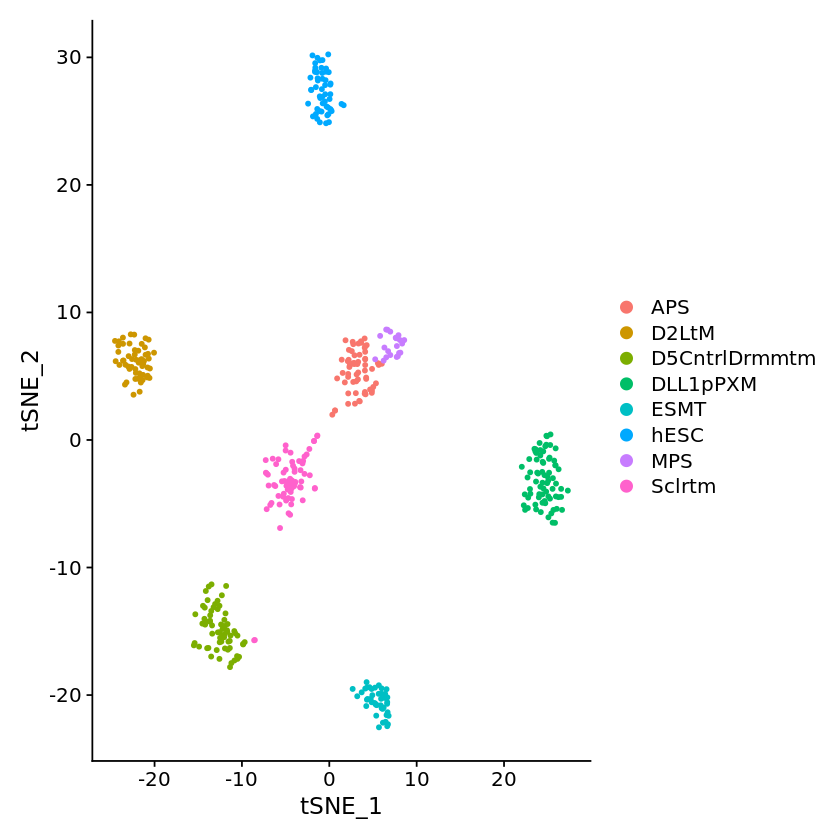

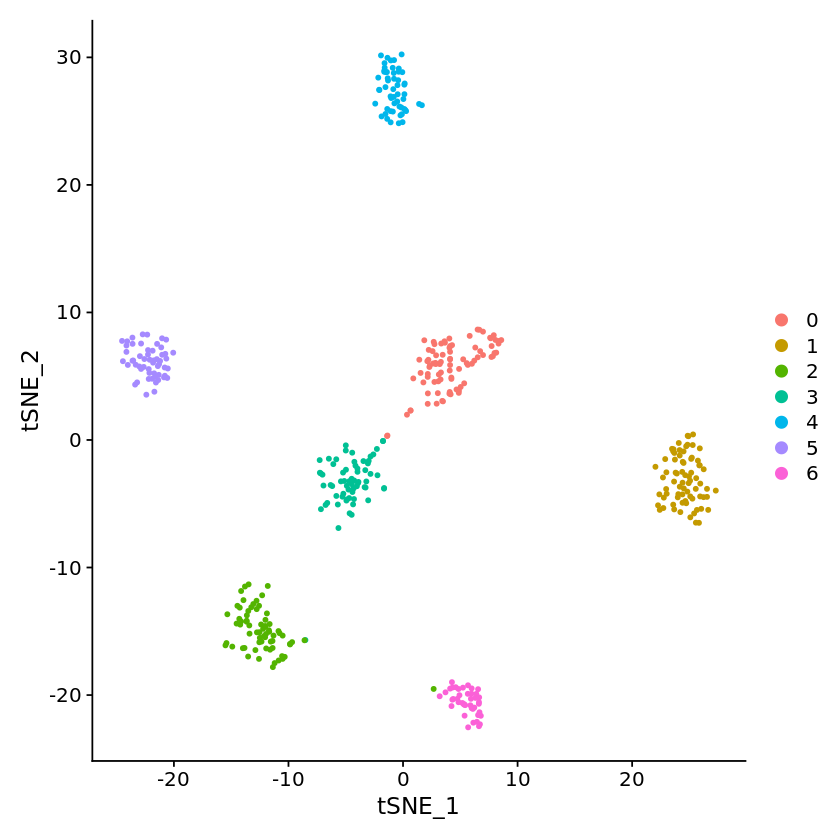

In [20]:
dataset_name='Kohinbulk_filtered'

sce=read_in_data(dataset_name);seurat=as.Seurat(sce, data=NULL)

seurat_hvg <- NormalizeData(seurat)

all.genes <- rownames(seurat_hvg)
seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

seurat_hvg <- FindVariableFeatures(seurat_hvg, selection.method = "vst", nfeatures = 2000)

seurat_hvg_pca <- RunPCA(seurat_hvg, features = VariableFeatures(object = seurat_hvg))


seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = res)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)    

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")   

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")  

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='APS',ident.2='MPS',group.by='phenoid',logfc.threshold=lfc_thres)    

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.APS.MPS.tsv',dataset_name),sep='\t')    


markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='MPS',ident.2='APS',group.by='phenoid',logfc.threshold=lfc_thres)    

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.MPS.APS.tsv',dataset_name),sep='\t') 

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='APS',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.APS.tsv',dataset_name),sep='\t')

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='MPS',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.MPS.tsv',dataset_name),sep='\t')

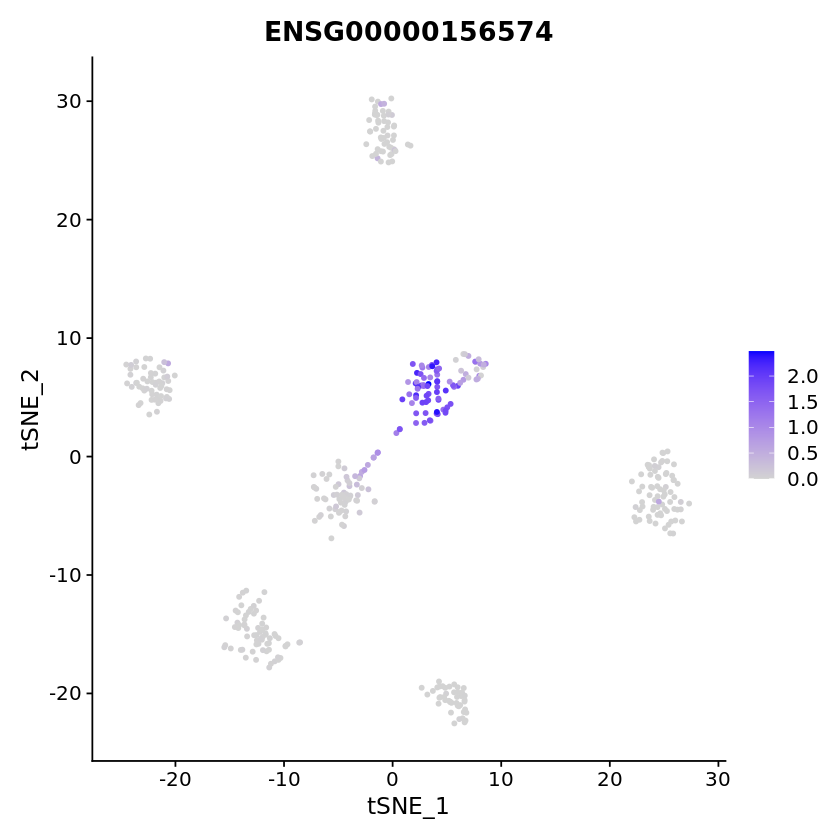

In [25]:
FeaturePlot(seurat_hvg_pca_label_cluster_tsne,features=c('ENSG00000156574'))

# Lung

Centering and scaling data matrix

PC_ 1 
Positive:  Coro1a, Laptm5, Cd52, Arhgdib, Tyrobp, Ptprc, Cd53, Fcer1g, Ctss, Rac2 
	   Lcp1, Selplg, Lsp1, Itgb2, Sfpi1, Alox5ap, Ptpn6, Pld4, Ccl6, Lyz2 
	   Cybb, Plbd1, Cd68, Slfn2, Limd2, Cd74, Hck, Ncf2, Fyb, Irf5 
Negative:  Serping1, Bgn, Sod3, Gsn, Loxl1, Olfml3, Pcolce, Ogn, Pcolce2, Mgp 
	   Inmt, Col1a2, Plxdc2, Mxra8, Dpep1, Rarres2, Fbln1, Gpx3, Crispld2, Nbl1 
	   Col6a1, Sparcl1, Fhl1, Col6a2, Mmp2, Ms4a4d, Col3a1, Mfap4, Adh1, Dpt 
PC_ 2 
Positive:  Cyp4b1, Aqp1, Tinagl1, Lyve1, Slco2a1, Tie1, Clu, Emcn, Tek, Kdr 
	   Id3, Tmcc2, Sox17, Gja4, Cdc42ep1, Adcy4, Efna1, Car4, Sema3c, Itga1 
	   Tmem204, Bmp6, Pcdh1, Wfdc1, Tsc22d1, Dpysl2, Mfap2, Ier3, Mmrn2, Cadm1 
Negative:  Tyrobp, Lsp1, Fcer1g, Ctss, Laptm5, Gm2a, Coro1a, Sfpi1, Cd68, Ccl6 
	   Alox5ap, Cybb, Pld4, Ms4a6c, Cebpb, Cd52, Lgals3, Cd300a, Itgb2, Plbd1 
	   Ptprc, Irf5, Ncf2, Csf1r, Hck, Clec4a3, Fgr, Cd53, Mpeg1, Myo1f 
PC_ 3 
Positive:  Wfdc2, Cbr2, Cldn3, Sftpb, S

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1716
Number of edges: 48156

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8940
Number of communities: 19
Elapsed time: 0 seconds


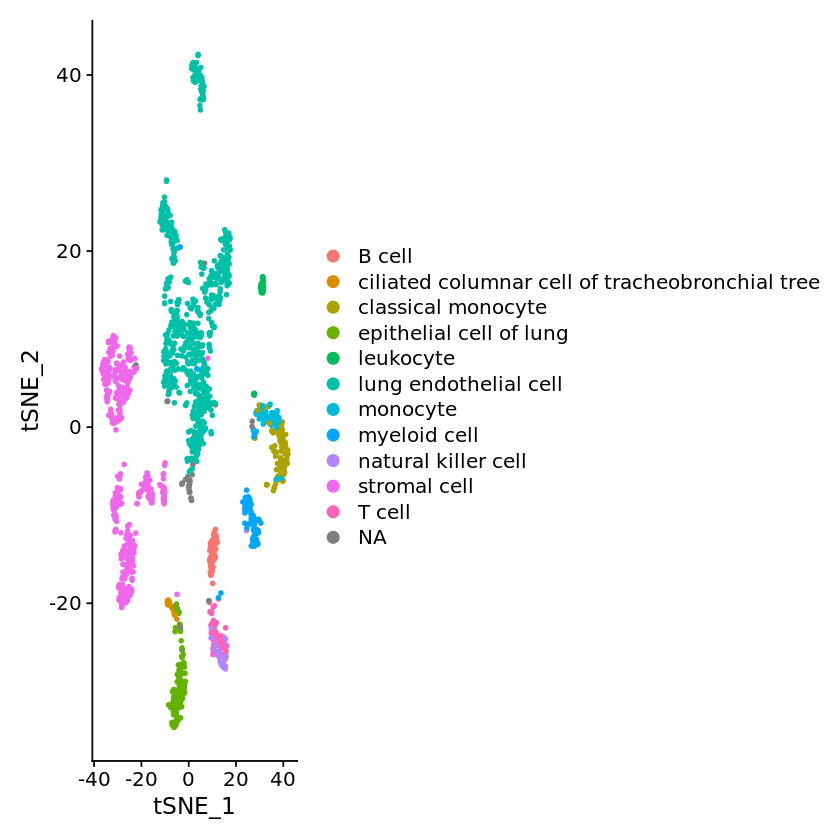

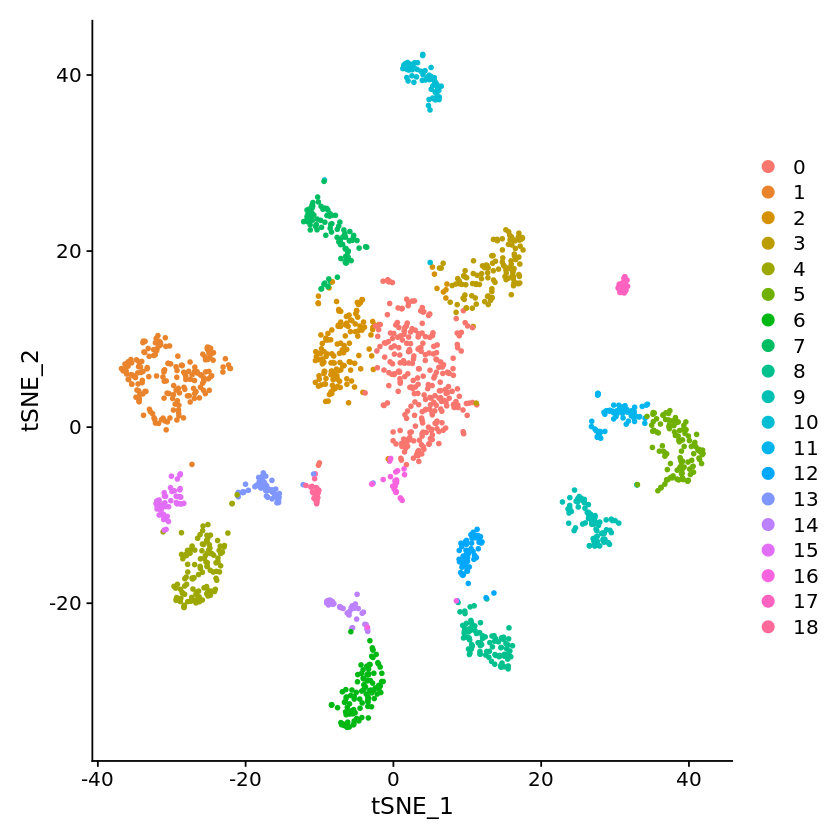

In [15]:
dataset_name='TabulaLung_filtered'

sce=read_in_data(dataset_name);seurat=as.Seurat(sce, data=NULL)

seurat_hvg <- NormalizeData(seurat)

all.genes <- rownames(seurat_hvg)
seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

seurat_hvg <- FindVariableFeatures(seurat_hvg, selection.method = "vst", nfeatures = 2000)

seurat_hvg_pca <- RunPCA(seurat_hvg, features = VariableFeatures(object = seurat_hvg))


seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = res)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)    

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")   

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")  

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='T cell',ident.2='natural killer cell',group.by='phenoid',logfc.threshold=lfc_thres)     

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.T_cell.natural_killer_cell.tsv',dataset_name),sep='\t')

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='natural killer cell',ident.2='T cell',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.natural_killer_cell.T_cell.tsv',dataset_name),sep='\t') 

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='natural killer cell',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.natural_killer_cell.tsv',dataset_name),sep='\t') 

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='T cell',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.T_cell.tsv',dataset_name),sep='\t') 

# Liver

Centering and scaling data matrix

PC_ 1 
Positive:  TMSB10, TMSB4X, HLA-B, HLA-E, CYBA, ARHGDIB, RPS2, VIM, SLC25A6, SH3BGRL3 
	   PTMA, HNRNPA1, CD74, FOS, CLIC1, RPS4Y1, CORO1A, ARPC1B, LAPTM5, TYROBP 
	   S100A4, S100A6, GSTP1, JUNB, FXYD5, ACTG1, FCER1G, S100A11, COTL1, CXCR4 
Negative:  APOC3, RBP4, APOA2, ALB, APOC1, FGA, MAT1A, CYP2E1, AMBP, HP 
	   APOH, AZGP1, APCS, FGB, TTR, MGST1, HPX, RARRES2, SERPINC1, ANG 
	   SERPINA1, APOA1, VTN, C1S, ORM1, FGL1, FGG, ORM2, ADH1B, ALDOB 
PC_ 2 
Positive:  LIFR, GNG11, HSPG2, PTPRB, TM4SF1, ID3, ID1, RAMP3, TIMP3, IFI27 
	   DNASE1L3, ENG, CCL14, TIMP1, EGFL7, IGFBP7, SDPR, IL33, PCAT19, NPDC1 
	   TFPI, TSPAN7, PLPP3, APP, IL6ST, CLDN5, PRSS23, FCN3, C7, RNASE1 
Negative:  NKG7, CCL5, GZMA, CORO1A, CST7, CD7, KLRB1, KLRD1, CXCR4, CCL4 
	   RAC2, ACAP1, PRF1, CTSW, CD69, TRBC2, CD247, CD48, CD2, KLRF1 
	   CMC1, IL32, ALOX5AP, TRBC1, LSP1, GZMK, DUSP2, CD3E, TRAC, CD3D 
PC_ 3 
Positive:  AIF1, CD163, FTL, LST1, MS4A7, CTSS, C1QA, C1QB, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8444
Number of edges: 278643

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8898
Number of communities: 21
Elapsed time: 0 seconds


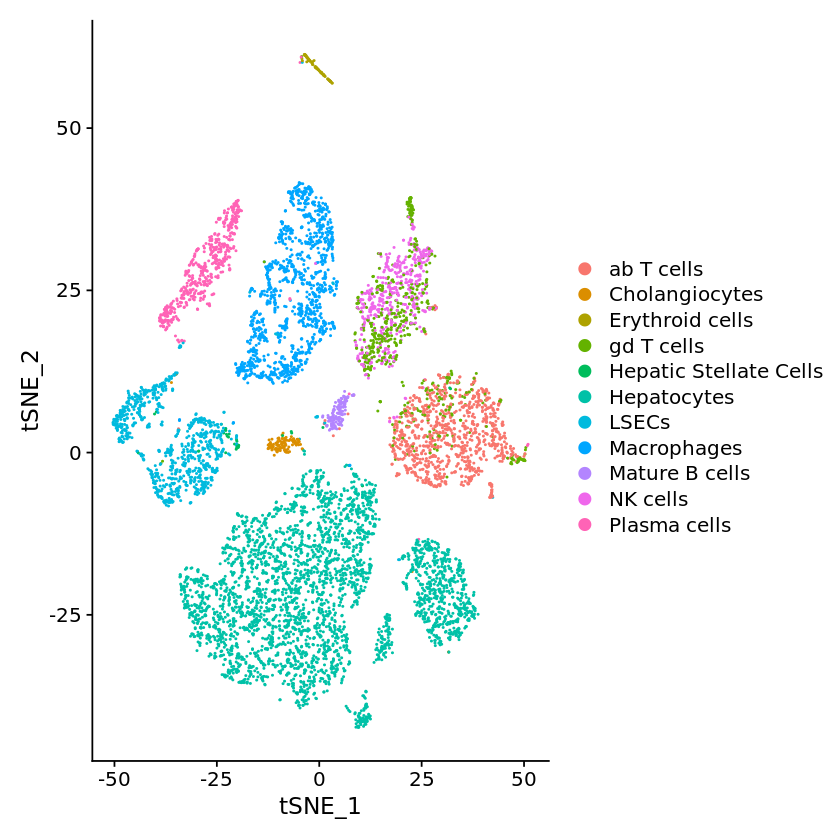

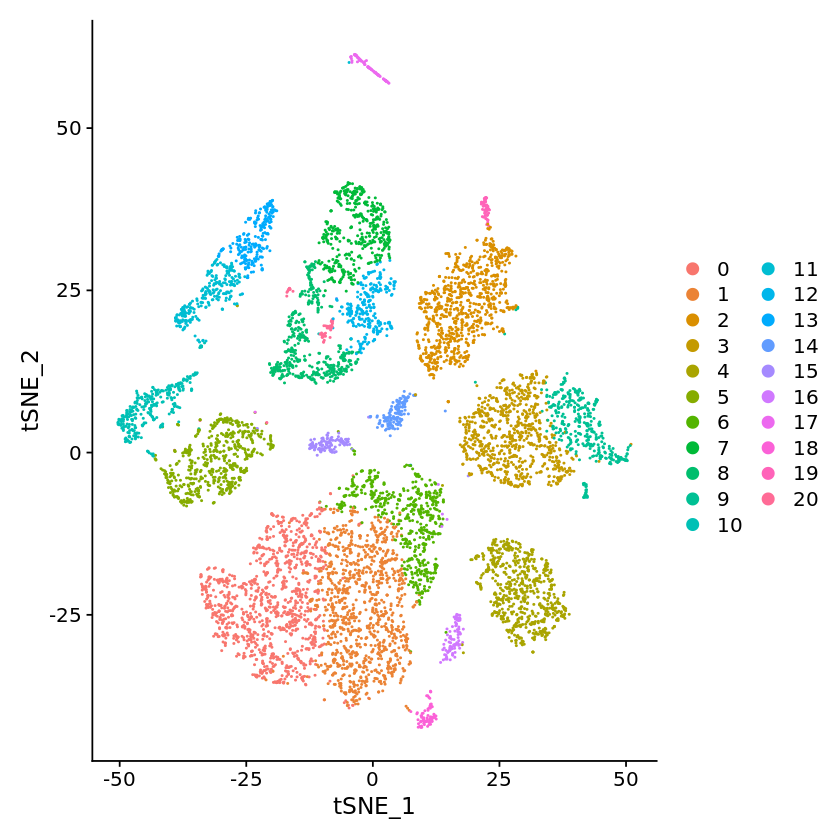

In [26]:
dataset_name='HumanLiver_filtered'

sce=read_in_data(dataset_name);seurat=as.Seurat(sce, data=NULL)

seurat_hvg <- NormalizeData(seurat)

all.genes <- rownames(seurat_hvg)
seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

seurat_hvg <- FindVariableFeatures(seurat_hvg, selection.method = "vst", nfeatures = 2000)

seurat_hvg_pca <- RunPCA(seurat_hvg, features = VariableFeatures(object = seurat_hvg))


seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = res)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)    

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")   

DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")  

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='gd T cells',ident.2='ab T cells',group.by='phenoid',logfc.threshold=lfc_thres)    

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.gd_T_cells.ab_T_cells.tsv',dataset_name),sep='\t')    

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='gd T cells',ident.2='NK cells',group.by='phenoid',logfc.threshold=lfc_thres)    

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.gd_T_cells.NK_cells.tsv',dataset_name),sep='\t') 

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='gd T cells',group.by='phenoid',logfc.threshold=lfc_thres)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.gd_T_cells.tsv',dataset_name),sep='\t') 

markers=FindMarkers(seurat_hvg_pca_label_cluster, ident.1='NK cells',group.by='phenoid',logfc.threshold=0)  

write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.NK_cells.tsv',dataset_name),sep='\t') 

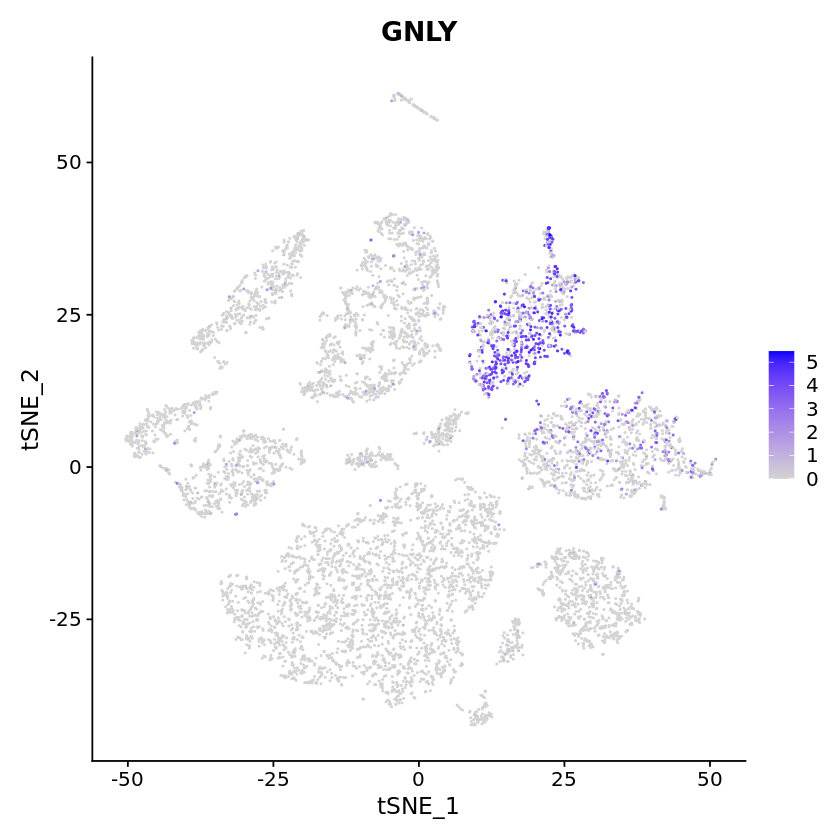

In [27]:
FeaturePlot(seurat_hvg_pca_label_cluster_tsne,features=c('GNLY'))

In [ ]:
'datasets/extract/%s.clustering.%s.deg.tsv',dataset_name,res_str),sep='\t')    

In [13]:
markers <- FindAllMarkers(seurat_hvg_pca_label_cluster, test.use="wilcox")#, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
write.table(markers,
            sprintf('datasets/extract/%s.truelabel.deg.tsv',dataset_name,res_str),sep='\t')    

[1] 1


In [ ]:
write.table(markers,
            sprintf('datasets/extract/%s.clustering.%s.deg.tsv',dataset_name,res_str),sep='\t')    

In [ ]:
FindAllMarkers(seurat_hvg_pca_label_cluster, test.use="wilcox")

In [23]:
head(FindMarkers(seurat_hvg_pca_label_cluster, ident.1='MPS',ident.2='APS',group.by='phenoid'))

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000225840,4.111423e-12,1.0948688,1,1,6.041325e-08
ENSG00000130741,4.111423e-12,0.7811497,1,1,6.041325e-08
ENSG00000108953,4.111423e-12,0.7299055,1,1,6.041325e-08
ENSG00000179218,5.099574e-12,0.8107667,1,1,7.493315e-08
ENSG00000280623,5.884026e-12,2.6592411,1,1,8.645988e-08
ENSG00000125691,7.287100e-12,0.6253840,1,1,1.070766e-07


In [26]:
help(FeaturePlot)

In [32]:
help(FindMarkers)

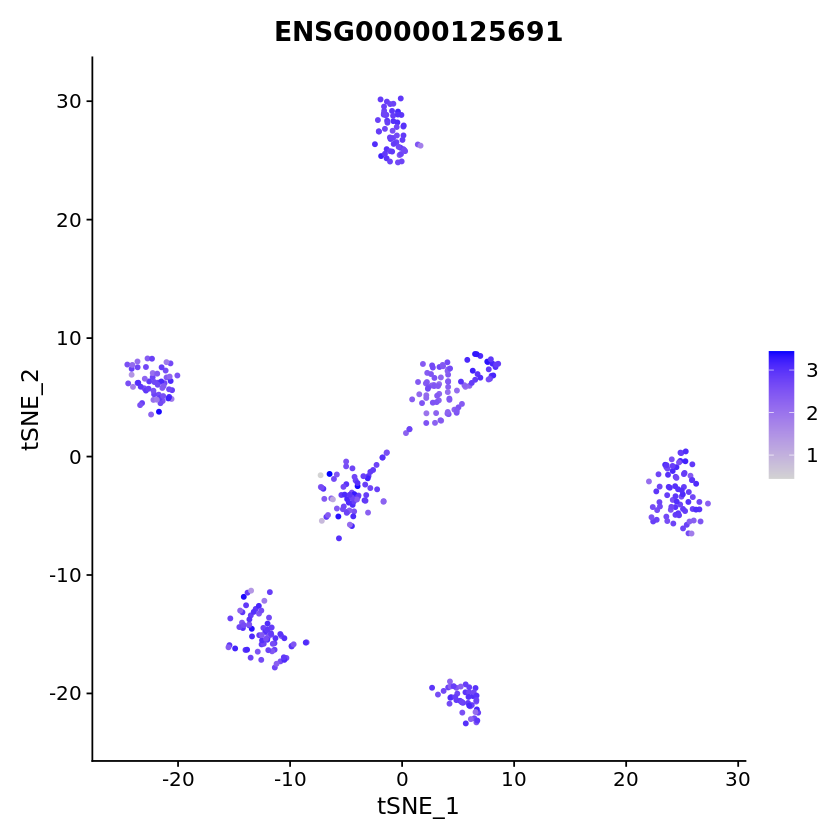

In [31]:
FeaturePlot(seurat_hvg_pca_label_cluster_tsne,features='ENSG00000125691')

In [39]:
slotNames(seurat_hvg_pca_label_cluster[['RNA']])

[1] "counts"        "data"          "scale.data"    "key"          
[5] "assay.orig"    "var.features"  "meta.features" "misc"

In [34]:
FindMarkers(seurat_hvg_pca_label_cluster, logfc.threshold=1, ident.1='APS',ident.2='MPS',group.by='phenoid')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000225840,4.111423e-12,-1.094869,1.000,1.000,6.041325e-08
ENSG00000280623,5.884026e-12,-2.659241,1.000,1.000,8.645988e-08
ENSG00000156574,1.698663e-11,1.210054,1.000,1.000,2.496016e-07
ENSG00000156966,2.244990e-11,-1.295338,1.000,1.000,3.298788e-07
ENSG00000055732,2.406473e-11,-1.475823,1.000,1.000,3.536071e-07
ENSG00000139163,2.741930e-10,-1.030742,1.000,1.000,4.028992e-06
ENSG00000130309,2.928159e-10,-1.024443,1.000,1.000,4.302636e-06
ENSG00000170542,3.126719e-10,-1.310956,1.000,1.000,4.594400e-06
ENSG00000143951,3.338405e-10,1.079247,1.000,1.000,4.905453e-06


In [40]:
help(FindMarkers)

In [41]:
FindMarkers(seurat_hvg_pca_label_cluster, test.use='LR',logfc.threshold=1, ident.1='APS',ident.2='MPS',group.by='phenoid')

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000225840,8.456204e-23,-1.094869,1.000,1.000,1.242555e-18
ENSG00000280623,4.106517e-20,-2.659241,1.000,1.000,6.034116e-16
ENSG00000055732,1.240758e-18,-1.475823,1.000,1.000,1.823170e-14
ENSG00000156574,4.473982e-18,1.210054,1.000,1.000,6.574069e-14
ENSG00000156966,1.279206e-17,-1.295338,1.000,1.000,1.879665e-13
ENSG00000170542,8.313643e-17,-1.310956,1.000,1.000,1.221607e-12
ENSG00000130309,3.123499e-15,-1.024443,1.000,1.000,4.589670e-11
ENSG00000139163,6.779313e-15,-1.030742,1.000,1.000,9.961523e-11
ENSG00000143951,1.530238e-13,1.079247,1.000,1.000,2.248532e-09


In [35]:
help(FindMarkers)

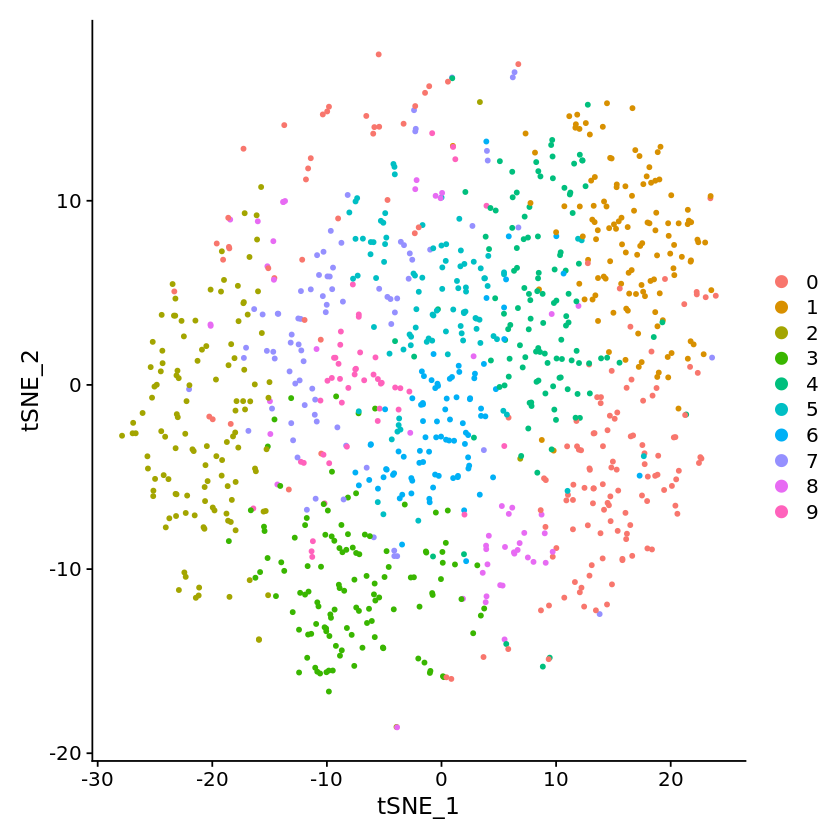

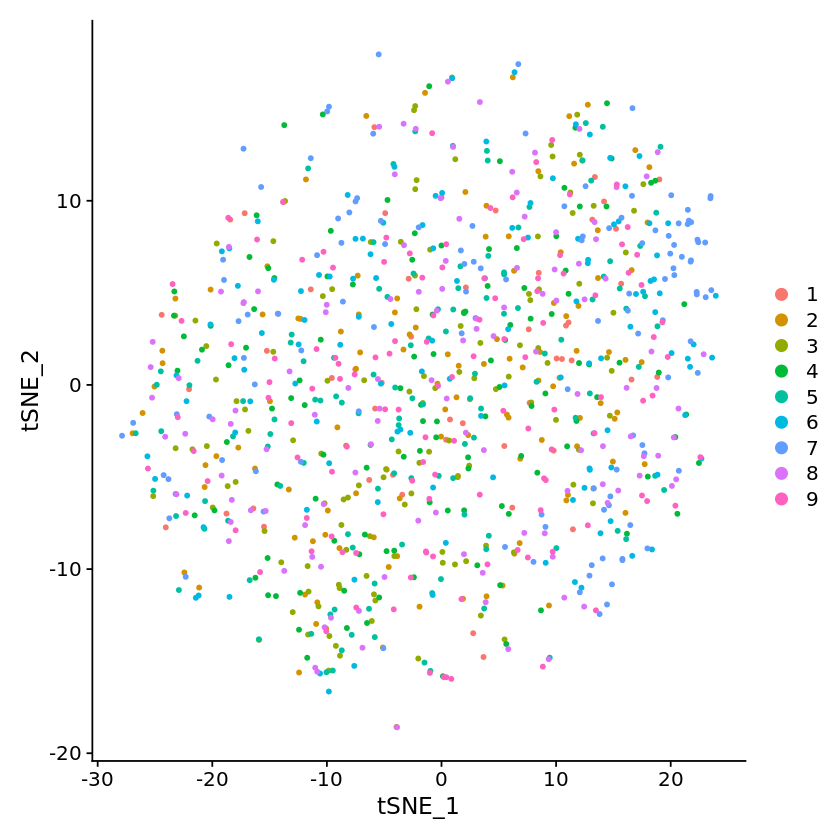

In [16]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")    
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")    

In [ ]:
help(str_replace)

In [22]:
Idents(seurat_hvg_pca_label_cluster)=seurat_hvg_pca_label_cluster@meta.data['seurat_clusters']
markers <- FindAllMarkers(seurat_hvg_pca_label_cluster, test.use="wilcox")#, only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
#
#write.table(markers,sprintf('datasets/extract/%s.clusteringdeg.%s.tsv',save_name,'0_5'),sep='\t')

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



In [24]:
markers

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ENSG00000163508,3.108034e-53,0.8602427,1.000,0.331,4.566944e-49,0,ENSG00000163508
ENSG00000164687,1.392503e-46,1.4342003,1.000,0.994,2.046144e-42,0,ENSG00000164687
ENSG00000156574,3.351416e-46,1.4944646,1.000,0.528,4.924571e-42,0,ENSG00000156574
ENSG00000185155,5.968473e-46,1.8390982,1.000,0.972,8.770074e-42,0,ENSG00000185155
ENSG00000145864,8.406233e-46,0.3858066,0.965,0.300,1.235212e-41,0,ENSG00000145864
ENSG00000104371,1.941737e-45,2.3917572,1.000,0.678,2.853188e-41,0,ENSG00000104371
ENSG00000173401,2.403905e-42,0.5499653,1.000,0.600,3.532298e-38,0,ENSG00000173401
ENSG00000185885,3.831346e-42,1.4865987,1.000,0.994,5.629779e-38,0,ENSG00000185885
ENSG00000153363,7.611356e-42,1.4542572,1.000,0.994,1.118413e-37,0,ENSG00000153363


In [23]:
help(FindAllMarkers)

In [295]:
seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 0.5)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 36888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6085
Number of communities: 2
Elapsed time: 0 seconds


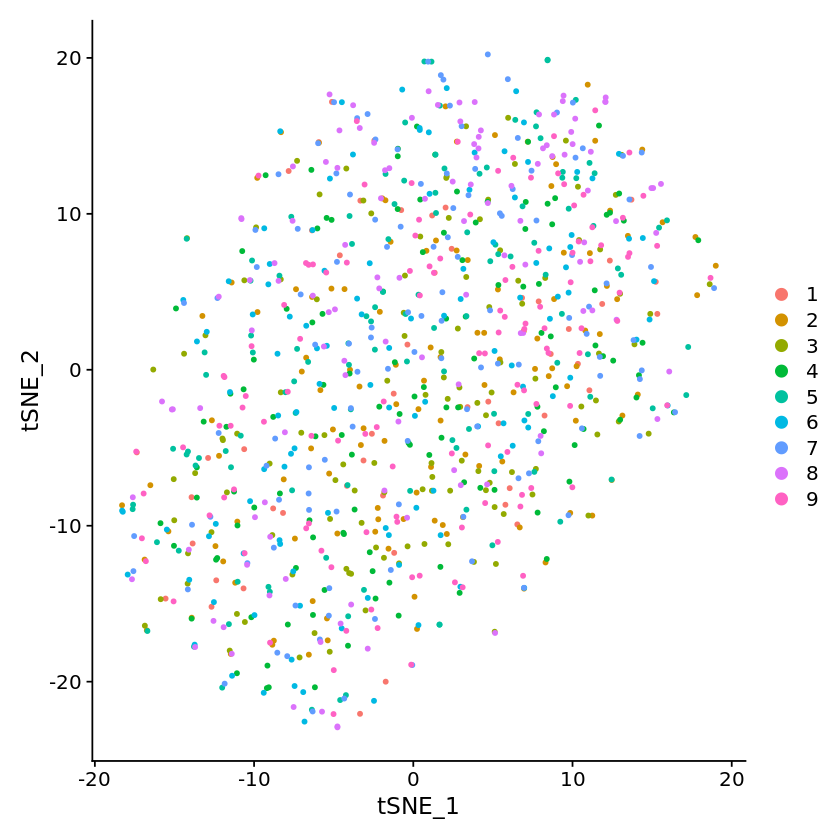

In [296]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")

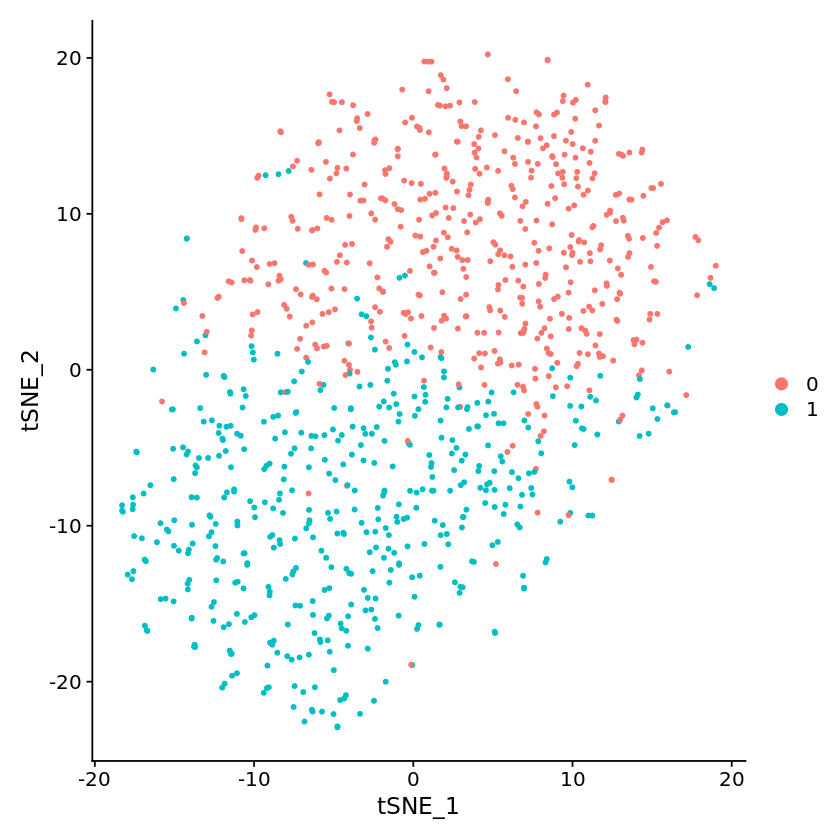

In [297]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")

In [298]:
#FeaturePlot(seurat_hvg_pca_label_cluster_tsne,'MKI67')

In [299]:
write.table(seurat_hvg_pca_label_cluster_tsne@meta.data['seurat_clusters'],sprintf('datasets/extract/%s.clusterlabel.%s.tsv',save_name,'0_5'),sep='\t')


In [300]:
seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 1.0)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 36888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4654
Number of communities: 6
Elapsed time: 0 seconds


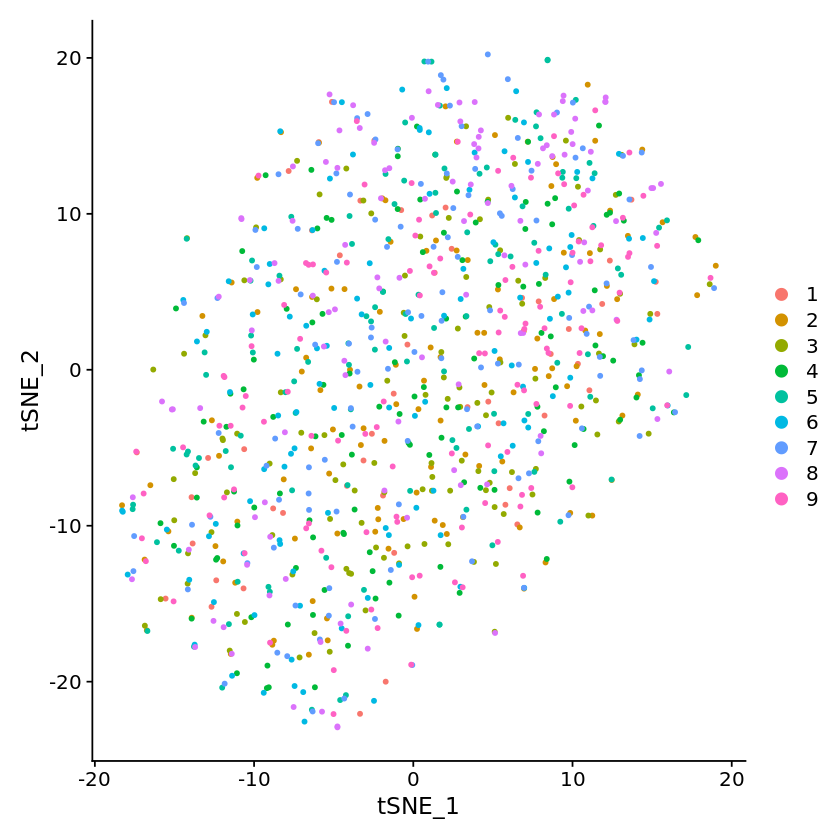

In [301]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")

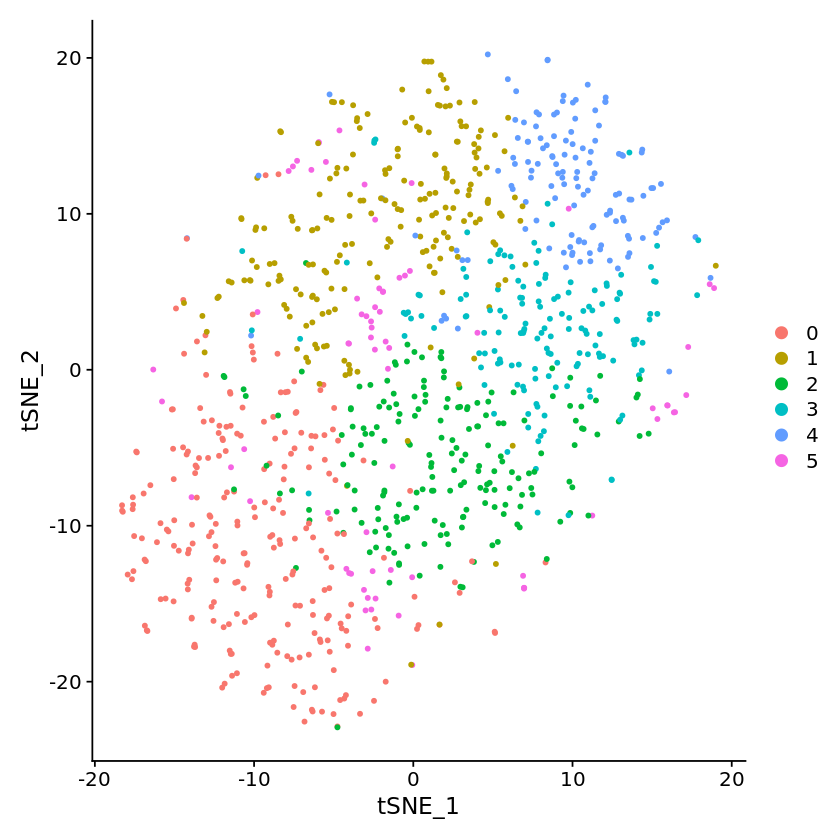

In [302]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")

In [303]:
write.table(seurat_hvg_pca_label_cluster_tsne@meta.data['seurat_clusters'],sprintf('datasets/extract/%s.clusterlabel.%s.tsv',save_name,'1_0'),sep='\t')

In [304]:
seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:10)
seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 1.5)
seurat_hvg_pca_label_cluster_tsne <- RunTSNE(seurat_hvg_pca_label_cluster, dims= 1:10)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1000
Number of edges: 36888

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3891
Number of communities: 10
Elapsed time: 0 seconds


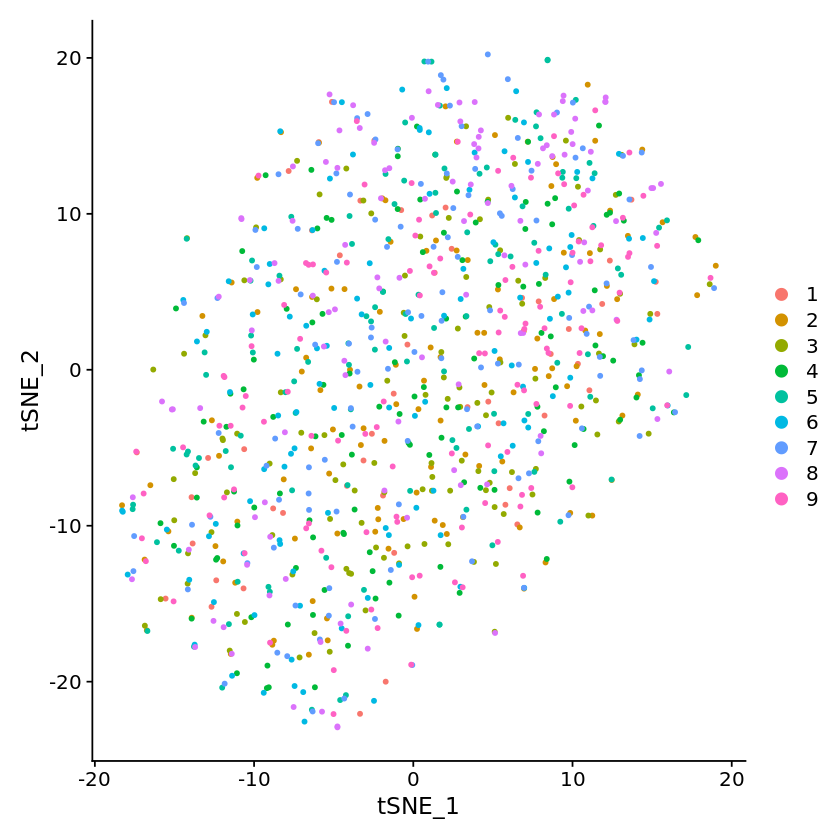

In [305]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='phenoid', reduction = "tsne")

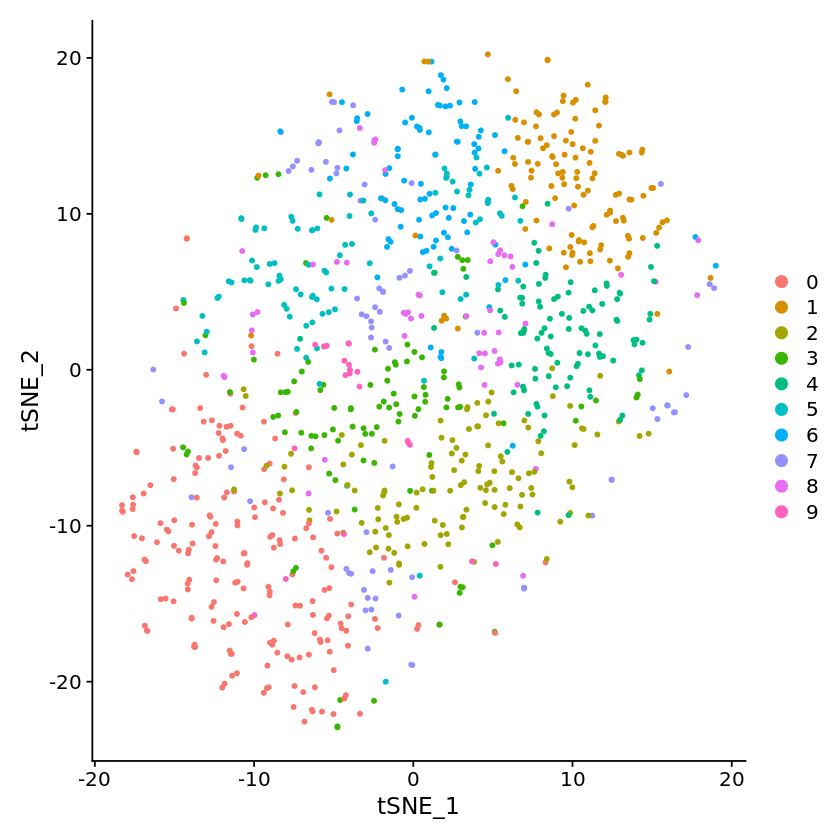

In [306]:
DimPlot(seurat_hvg_pca_label_cluster_tsne, group.by='seurat_clusters', reduction = "tsne")

In [307]:
write.table(seurat_hvg_pca_label_cluster_tsne@meta.data['seurat_clusters'],sprintf('datasets/extract/%s.clusterlabel.%s.tsv',save_name,'1_5'),sep='\t')

In [22]:
#Idents(seurat)=seurat@meta.data['seurat_clusters']
#markers <- FindAllMarkers(seurat, test.use="wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
#write.table(markers,sprintf('datasets/extract/%s.clusteringdeg.%s.tsv',save_name,'0_5'),sep='\t')
#write.table(seurat_hvg_pca_label_cluster@meta.data['seurat_clusters'],sprintf('datasets/extract/%s.clusterlabel.%s.tsv',save_name,0.1),sep='\t')
#DimPlot(seurat_hvg_pca_label_cluster, reduction = "tsne")

In [23]:
priunt(1)

ERROR: Error in priunt(1): 함수 "priunt"를 찾을 수 없습니다


In [ ]:
seurat1 <- FindNeighbors(seurat1, dims = 1:10)
seurat1 <- FindClusters(seurat1, resolution = 0.5)

Idents(seurat1)=seurat1@meta.data['seurat_clusters']
markers <- FindAllMarkers(seurat1, test.use="wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
write.table(markers,sprintf('datasets/extract/%s.clusteringdeg.%s.tsv',save_name,'0_5'),sep='\t')

DimPlot(seurat1, reduction = "tsne")

In [ ]:
seurat1 <- FindNeighbors(seurat1, dims = 1:10)
seurat1 <- FindClusters(seurat1, resolution = 1.0)

Idents(seurat1)=seurat1@meta.data['seurat_clusters']
markers <- FindAllMarkers(seurat1, test.use="wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
write.table(markers,sprintf('datasets/extract/%s.clusteringdeg.%s.tsv',save_name,'1_0'),sep='\t')

DimPlot(seurat1, reduction = "tsne")

In [ ]:
seurat1 <- FindNeighbors(seurat1, dims = 1:10)
seurat1 <- FindClusters(seurat1, resolution = 1.5)

Idents(seurat1)=seurat1@meta.data['seurat_clusters']
markers <- FindAllMarkers(seurat1, test.use="wilcox", only.pos = TRUE, min.pct = 0.1, logfc.threshold = 0.25)
write.table(markers,sprintf('datasets/extract/%s.clusteringdeg.%s.tsv',save_name,'1_5'),sep='\t')

DimPlot(seurat1, reduction = "tsne")